Generating 40401 rays...


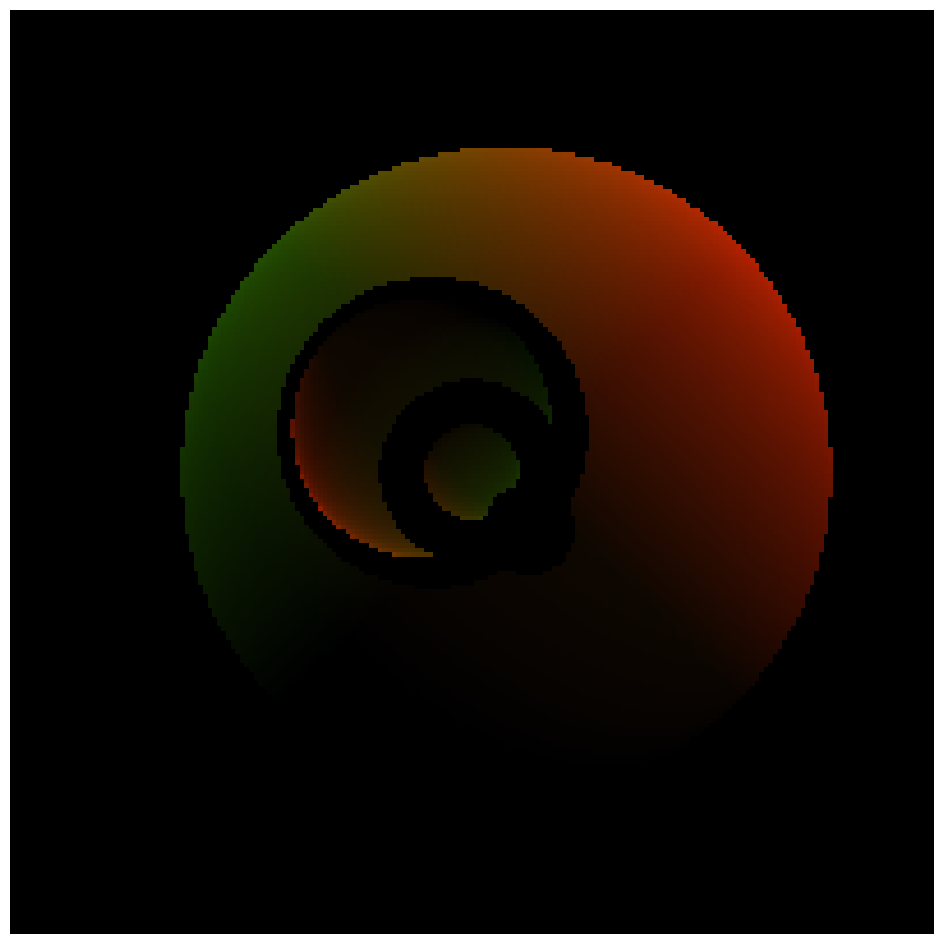

In [3]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from vector import Vector, Angle
from object import Sphere
from ray import Ray, Intersection
from material import Material
from colour import Colour
from light import GlobalLight, PointLight

base_material = Material()
emitive_material = Material(emitive=True)
reflective_material = Material(reflective=True)

glass = Material(reflective=False, transparent=True, refractive_index=1.52)

global_light_r = GlobalLight(vector=Vector(1, 1, 0), colour=Colour(255, 50, 50), strength=1, max_angle=np.radians(90), func=0)
global_light_g = GlobalLight(vector=Vector(-1, 1, 0), colour=Colour(50, 255, 50), strength=1, max_angle=np.radians(90), func=0)
global_light_b = GlobalLight(vector=Vector(1, 1, 1), colour=Colour(50, 50, 255), strength=1, max_angle=np.radians(90), func=0)
global_light_sources = [global_light_r, global_light_g, global_light_b]

point_light_sources = []

marble_1 = Sphere(id=0, centre=Vector(0, 0, 0), radius=0.5, material=glass, colour=Colour(100, 100, 100))
marble_2 = Sphere(id=1, centre=Vector(-0.25, 0.25, -1), radius=1, material=glass, colour=Colour(100, 100, 100))
marble_3 = Sphere(id=2, centre=Vector(0.25, -0.25, 1), radius=0.2, material=glass, colour=Colour(100, 100, 100))
sphere_1 = Sphere(id=3, centre=Vector(0.5, 0, -10), radius=5, material=base_material, colour=Colour(200, 100, 0))
spheres = [marble_1, marble_2, marble_3, sphere_1]

ray_origin = Vector(0, 0, 5)
rays = []

RAY_COUNT = 100   # = rays in each axis = 2 * ray count + 1 (for centre ray)
RAY_STEP = 0.005   # 0.003 = long focal distance

multiple = 1     # 1 is normal, 2 is ok, 5 is good, 10 is mega
RAY_COUNT *= multiple
RAY_STEP /= multiple

X_RAYS = [r*RAY_STEP for r in range(-RAY_COUNT, 0, 1)] + [r*RAY_STEP for r in range(0, RAY_COUNT + 1)]
Y_RAYS = [r*RAY_STEP for r in range(RAY_COUNT, 0, -1)] + [-r*RAY_STEP for r in range(0, RAY_COUNT + 1)]
Z = -1

MAX_BOUNCES = 100

TOTAL_RAYS = len(X_RAYS) * len(Y_RAYS)

print(f"Generating {TOTAL_RAYS} rays...")
for Y in Y_RAYS:
    for X in X_RAYS:
        ray = Ray(
            origin=ray_origin,
            D=Vector(x=X, y=Y, z=-1)
        )
        rays.append(ray)

# lightVector = Vector(3, 1, -0.75)     # infinite distance light source
max_angle = np.radians(90)
background_colour = Colour(0, 0, 1)
black_colour = Colour(0, 0, 1)

pixels = []

progress_milestones = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for i, ray in enumerate(rays):

    progress = (i+1) / len(rays) * 100
    if progress > progress_milestones[0]:
        progress_milestones.pop(0)
        print(f"Casting Rays: {progress:.0f}%", end="\r")

    ray_terminal = ray.nearestSphereIntersect(spheres, max_bounces=MAX_BOUNCES)

    if ray_terminal == None:
        pixels.append(background_colour.getList())

    else:
        pixels.append(ray_terminal.terminalRGB(
            spheres=spheres,
            background_colour=background_colour,
            global_light_sources=global_light_sources,
            point_light_sources=point_light_sources
        ).getList())

X_SIZE = len(X_RAYS)
Y_SIZE = len(Y_RAYS)

pixels = np.array(pixels).reshape((X_SIZE, Y_SIZE, 3))

plt.figure(figsize=(12, 12))    # 64 x 64 = high-res output
plt.imshow(pixels)
plt.axis('off')
plt.savefig('render_output.png', bbox_inches='tight')
plt.show()

In [8]:
def sphereExitRay(self, sphere, intersection):

    # refract at first intersection
    refracted_ray_D = self.D.refractInVector(intersection.normal, 1, sphere.material.refractive_index)

    # get internal ray
    internal_ray = Ray(
        origin=intersection.point.subtractVector(refracted_ray_D),
        D=refracted_ray_D
    )

    # get second intersection
    exit_intersection = internal_ray.sphereDiscriminant(sphere=sphere, point=1)

    exit_ray_D = None
    exit = False

    n = 0
    while (exit == False) & (n < 100):
        n+=1

        # refract exit ray
        exit_ray_D = refracted_ray_D.refractInVector(exit_intersection.normal.invert(), sphere.material.refractive_index, 1)

        if exit_ray_D != False:
            exit = True
        else:
            # TIR
            refracted_ray_D = refracted_ray_D.reflectInVector(exit_intersection.normal)
            # find next exit point
            exit_ray = Ray(
                origin=exit_intersection.point.subtractVector(refracted_ray_D),
                D=refracted_ray_D
            )
            exit_intersection = exit_ray.sphereDiscriminant(sphere=sphere, point=1)
        
    if exit == True:
        return Ray(
            exit_intersection.point,
            exit_ray_D
        )

    print("TIR")
    print(n)

    return None

ray = Ray(
    origin=Vector(0, 0, 5),
    D=Vector(0.0049751243781094535, y=0.09950248756218907, z=-0.9950248756218907)
)

intersection = ray.sphereDiscriminant(sphere=marble_1)

r = sphereExitRay(ray, marble_1, intersection=intersection)
if r != None:
    r.origin.describe()
    r.D.describe()

    next_intersect = r.nearestSphereIntersect(spheres=[sphere_1])
    if next_intersect != None:
        print(f"Next intersects: {next_intersect.object.id}")
        print(f"TerminalRGB:")
        print(next_intersect.terminalRGB(
            spheres=spheres,
            background_colour=background_colour,
            global_light_sources=global_light_sources,
            point_light_sources=point_light_sources
        ).getList())


for x in [-1, -0.9, -0.5, -0.1, 0, 0.1, 0.5, 0.9, 1]:

    ray = Ray(
        origin=Vector(x, 0, 5),
        D=Vector(0, 0, -1)
    )
    sphere = Sphere(id=0, centre=Vector(0, 0, 0), radius=1, material=glass, colour=Colour(100, 100, 100))

    intersection = ray.sphereDiscriminant(sphere=sphere)

    print()
    print(f"RESULTS for x={x}")
    r = sphereExitRay(ray, sphere, intersection=intersection)
    if r != None:
        r.origin.describe()
        r.D.describe()

        next_intersect = r.nearestSphereIntersect(spheres=[sphere_1])
        if next_intersect != None:
            print(f"Next intersects: {next_intersect.object.id}")
            print(f"TerminalRGB:")
            print(next_intersect.terminalRGB(
                spheres=spheres,
                background_colour=background_colour,
                global_light_sources=global_light_sources,
                point_light_sources=point_light_sources
            ).getList())

TIR
100

RESULTS for x=-1
x: 0.11111111111111116, y: 0.0, z: -0.9938079899999063
x: 0.9938079899999066, y: 0.0, z: 0.11111111111111095

RESULTS for x=-0.9
x: -0.16645429857990424, y: 0.0, z: -0.9860491704191396
x: 0.8148885067544485, y: 0.0, z: -0.5796177374438304

RESULTS for x=-0.5
x: -0.1554421650629284, y: 0.0, z: -0.9878449945819179
x: 0.3593056335272091, y: 0.0, z: -0.9332199428407063
Next intersects: 3
TerminalRGB:
[176, 54, 1]

RESULTS for x=-0.1
x: -0.03325874111279134, y: 0.0, z: -0.9994467750408691
x: 0.06685264792287804, y: 0.0, z: -0.9977628593336694
Next intersects: 3
TerminalRGB:
[77, 48, 1]

RESULTS for x=0
x: 0.0, y: 0.0, z: -1.0
x: 0.0, y: 0.0, z: -1.0
Next intersects: 3
TerminalRGB:
[77, 56, 1]

RESULTS for x=0.1
x: 0.03325874111279134, y: 0.0, z: -0.9994467750408691
x: -0.06685264792287804, y: 0.0, z: -0.9977628593336694
Next intersects: 3
TerminalRGB:
[76, 65, 1]

RESULTS for x=0.5
x: 0.1554421650629284, y: 0.0, z: -0.9878449945819179
x: -0.3593056335272091, y: 0.0

In [4]:
ray = Ray(
    origin=Vector(0, 0, 5),
    D=Vector(0.0049751243781094535, y=0.09950248756218907, z=-0.9950248756218907)
)

intersection = ray.sphereDiscriminant(sphere=marble_1)

print()
r = sphereExitRay(ray, sphere, intersection=intersection)
if r != None:
    r.origin.describe()
    r.D.describe()

    next_intersect = r.nearestSphereIntersect(spheres=[sphere_1])
    if next_intersect != None:
        print(f"Next intersects: {next_intersect.object.id}")
        print(f"TerminalRGB:")
        print(next_intersect.terminalRGB(
            spheres=spheres,
            background_colour=background_colour,
            global_light_sources=global_light_sources,
            point_light_sources=point_light_sources
        ).getList())

AttributeError: 'bool' object has no attribute 'reflectInVector'

In [3]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from vector import Vector, Angle
from object import Sphere
from ray import Ray, Intersection
from material import Material
from colour import Colour
from light import GlobalLight, PointLight

base_material = Material()
emitive_material = Material(emitive=True)
reflective_material = Material(reflective=True)

glass = Material(reflective=False, transparent=True, refractive_index=1.5)

global_light_r = GlobalLight(vector=Vector(1, 1, 0), colour=Colour(255, 50, 50), strength=5, max_angle=np.radians(90), func=0)
global_light_g = GlobalLight(vector=Vector(-1, 1, 0), colour=Colour(50, 255, 50), strength=5, max_angle=np.radians(90), func=0)
global_light_b = GlobalLight(vector=Vector(1, 1, 1), colour=Colour(50, 50, 255), strength=5, max_angle=np.radians(90), func=0)
global_light_sources = [global_light_r, global_light_g, global_light_b]

point_light_sources = []

marble_1 = Sphere(id=0, centre=Vector(0, 0, 0), radius=0.5, material=glass, colour=Colour(100, 100, 100))
marble_2 = Sphere(id=1, centre=Vector(-0.25, 0.25, -1), radius=1, material=glass, colour=Colour(100, 100, 100))
marble_3 = Sphere(id=2, centre=Vector(0.25, -0.25, 1), radius=0.2, material=glass, colour=Colour(100, 100, 100))
sphere_1 = Sphere(id=3, centre=Vector(0.5, 0, -10), radius=5, material=base_material, colour=Colour(200, 100, 0))
spheres = [marble_1, sphere_1]

ray = Ray(
    origin=Vector(0, 0, 5),
    D=Vector(0.0049751243781094535, y=0.09950248756218907, z=-0.9950248756218907)
)

nearest_intersect = ray.nearestSphereIntersect(spheres, max_bounces=10)
print(nearest_intersect.intersects)
print(nearest_intersect.object.id)
nearest_intersect.terminalRGB(
    spheres=spheres,
    background_colour=background_colour,
    global_light_sources=global_light_sources,
    point_light_sources=point_light_sources
).getList()

TIR
x: 0, y: 0, z: 5
x: 0.0049751243781094535, y: 0.09950248756218907, z: -0.9950248756218907



AttributeError: 'NoneType' object has no attribute 'intersects'

In [5]:
t = Vector(-1, -1, -1)

t.normalise().describe()

x: -0.5773502691896258, y: -0.5773502691896258, z: -0.5773502691896258


In [4]:
ray = Ray(
    origin=Vector(x=0.0494505494060454, y=-0.49450549406045413, z=-0.05494505899047166),
    D=Vector(x=-0.09890109881209082, y=0.9890109881209083, z=0.10989011798094343)
)

d = ray.sphereDiscriminant(marble_1)

d.point.describe()

d = ray.sphereDiscriminant(marble_1, point=1)

d.point.describe()

x: 0.0494505494060454, y: -0.49450549406045413, z: -0.05494505899047166
x: -0.049450549406045416, y: 0.49450549406045413, z: 0.05494505899047177


In [12]:

def refract(self, nearestIntersection)
reflected_ray_D = self.D.refractInVector(nearestIntersection.normal, 1, nearestIntersection.object.material.refractive_index)

exit_ray = False

exit_intersection = nearestIntersection
exit_ray_D = reflected_ray_D

n = 0
limit = 100

# keep calculating exit ray
while exit_ray == False:

    print(n)

    inverted_ray = Ray(
        origin=exit_intersection.point.addVector(exit_ray_D),
        D=exit_ray_D.invert()
    )
    exit_intersection = inverted_ray.sphereDiscriminant(
        sphere=nearestIntersection.object,
        point=0
    )
    exit_ray = inverted_ray.D.invert().refractInVector(exit_intersection.normal.invert(), nearestIntersection.object.material.refractive_index, 1)
    
    # if TIR, reflect instead
    if exit_ray == False:
        exit_ray_D = exit_ray_D.reflectInVector(exit_intersection.normal)

    n += 1
    if n >= limit:
        print("EXIT")
        return None 

False 0.10000000000000009 2.1
z: 1.1
Intersects: True
x: 0.0, y: 0.0, z: -1.0
x: 0.0, y: 0.0, z: -1.0

False 0.0 2.0
z: 1.0
Intersects: True
x: 0.0, y: 0.0, z: -1.0
x: 0.0, y: 0.0, z: -1.0

True -0.09999999999999998 1.9
z: 0.9
Intersects: True
x: 0.0, y: 0.0, z: 0.9999999999999999
x: 0.0, y: 0.0, z: 1.0

True -1.0 1.0
z: 0
Intersects: True
x: 0.0, y: 0.0, z: 1.0
x: 0.0, y: 0.0, z: 1.0

True -1.9 0.09999999999999998
z: -0.9
Intersects: True
x: 0.0, y: 0.0, z: 1.0
x: 0.0, y: 0.0, z: 1.0

True -2.0 0.0
z: -1.0
Intersects: True
x: 0.0, y: 0.0, z: 1.0
x: 0.0, y: 0.0, z: 1.0

z: -1.1
Intersects: False



In [13]:
ray = Ray(
    origin=Vector(0.1, 0, 5),
    D=Vector(0, 0, -1)
)

sphere = Sphere(
    centre=Vector(0, 0, 0), radius=1, material=base_material, colour=Colour(0, 0, 0)
)

d = ray.nearestSphereIntersect(spheres=[sphere])

d.intersects
d.point.describe()
d.normal.describe()
print()

ray = Ray(
    origin=d.point,
    D=ray.D.refractInVector(d.normal, 1, 1.5)
)

ray.origin.describe()
ray.D.describe()
print()

d = ray.nearestSphereIntersect(spheres=[sphere])

d.intersects
d.point.describe()
d.normal.describe()
print()

ray = Ray(
    origin=d.point,
    D=ray.D.refractInVector(d.normal.invert(), 1.5, 1)
)

ray.origin.describe()
ray.D.describe()
print()


x: 0.1, y: 0.0, z: 0.9949874371066194
x: 0.10000000000000006, y: 0.0, z: 0.99498743710662

x: 0.1, y: 0.0, z: 0.9949874371066194
x: -0.033445034506863806, y: 0.0, z: -0.9994405583459353

x: 0.03325874111279131, y: 0.0, z: -0.9994467750408684
x: 0.03325874111279132, y: 0.0, z: -0.9994467750408685

x: 0.03325874111279131, y: 0.0, z: -0.9994467750408684
x: -0.06685264792287803, y: 0.0, z: -0.9977628593336695



In [9]:
ray = Ray(
    origin=Vector(0.3, 0, 0),
    D=Vector(0, 0, -1)
)

sphere = Sphere(
    centre=Vector(0, 0, 0), radius=1, material=base_material, colour=Colour(0, 0, 0)
)

d = ray.sphereDiscriminant(sphere)

d.intersects
d.point.describe()
d.normal.describe()

r = ray.D.refractInVector(d.normal, 1, 1.5)

r.describe()

x: 0.3, y: 0.0, z: -0.9539392014169457
x: 0.3, y: 0.0, z: -0.9539392014169457
x: -0.4847266094173705, y: 0.0, z: 0.8746657156438339


In [4]:
refractive_index_air = 1
refractive_index_glass = 1.5

def refractInVector(self, B, r_index_a, r_index_b):
    v = self.normalise()
    normal = B.normalise()
    n = r_index_a / r_index_b
    cosI = -normal.dotProduct(self)
    sinT2 = n**2 * (1 - cosI**2)

    if sinT2 > 1:
        return self.reflectInVector(B)

    cosT = math.sqrt(1 - sinT2)
    return self.scaleByLength(n).addVector(B.scaleByLength(n * cosI - cosT))
    
ray = Ray(
    origin=Vector(0.3, 0, 5),
    D=Vector(0.1, 0, -1)
)

ray.origin.describe()
ray.D.describe()

test = refractInVector(ray.D, intersect.normal, refractive_index_air, refractive_index_glass)

test.describe()

x: 0.3, y: 0, z: 5
x: 0.09950371902099893, y: 0.0, z: -0.9950371902099893
x: -0.0023803436460171634, y: 0.0, z: -0.9999971669780505
